In [1]:
import xtrack as xt
import ruamel.yaml
import pickle
import numpy as np
import json
import matplotlib.pyplot as plt

# Initialize yaml reader
ryaml = ruamel.yaml.YAML()

In [2]:
collider = xt.Multiline.from_json(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/collider/collider.json"
)
#collider.build_trackers()

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [3]:
# load dictionnary of elements from pickle
with open(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/dynamic_configure.pkl",
    "rb",
) as fid:
    dic_elements = pickle.load(fid)

In [4]:
l_xrange = []
d_element_attr_vals = { 'lhcb1': {}, 'lhcb2': {}}
for on_sep, d_beam in sorted(dic_elements.items()):
    l_xrange.append(on_sep)
    for beam_temp, d_bb in d_beam.items():
        for type_bb, d_elements in d_bb.items():
            for element, d_attr in d_elements.items():
                if element not in d_element_attr_vals[beam_temp]:
                    d_element_attr_vals[beam_temp][element] = {}

                for attr, val in d_attr.items():
                    if attr in d_element_attr_vals[beam_temp][element]:
                        d_element_attr_vals[beam_temp][element][attr].append(val)
                    else:
                        d_element_attr_vals[beam_temp][element][attr] = [val]

In [5]:
d_element_attr_vals["lhcb1"]["bb_lr.l5b1_25"]["other_beam_shift_y"]

[-0.0005677350205671092,
 -0.0005455772962586345,
 -0.0005229104623952929,
 -0.0005002432539159345,
 -0.0004775757826640986,
 -0.00045490807914269214,
 -0.0004322401394621323,
 -0.00040957198386659124,
 -0.00038690366909711156,
 -0.00036423531148090744,
 -0.00034156712121348026,
 -0.00031889945111083747,
 -0.0002962328739259389,
 -0.0002735683010849394,
 -0.0002509071723618487,
 -0.00022825176802358316,
 -0.00020560574762810518,
 -0.0001829751267259886,
 -0.00016037016751033968,
 -0.00013780932930056102,
 -0.00011532833987671223,
 -9.30037037828524e-05,
 -7.102434483315497e-05,
 -4.9967362827298335e-05,
 -3.225333320589886e-05,
 -1.8084703678416826e-06]

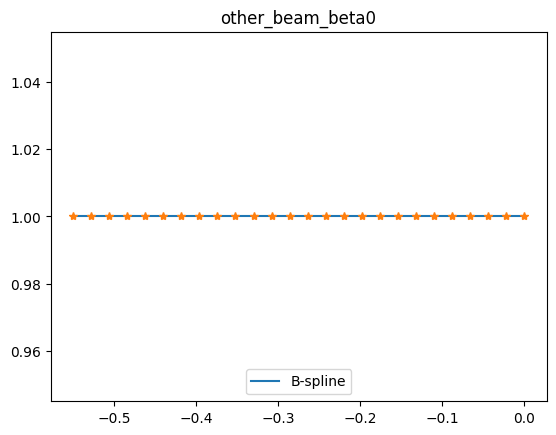

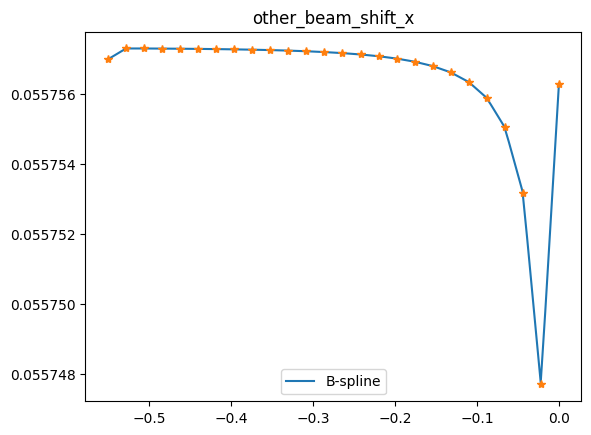

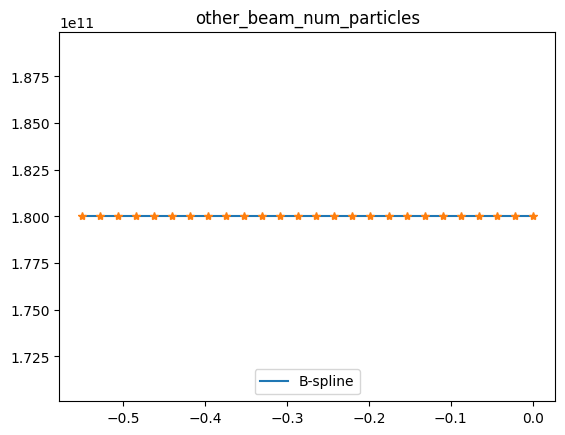

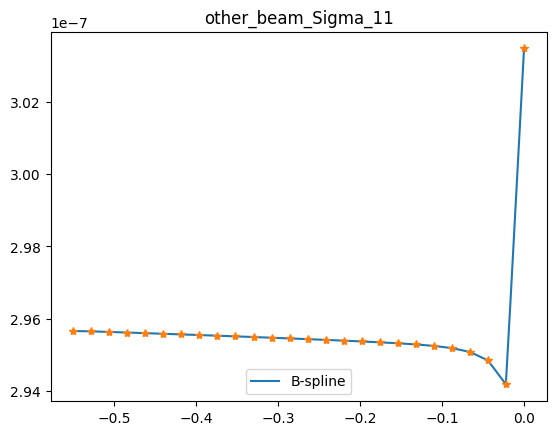

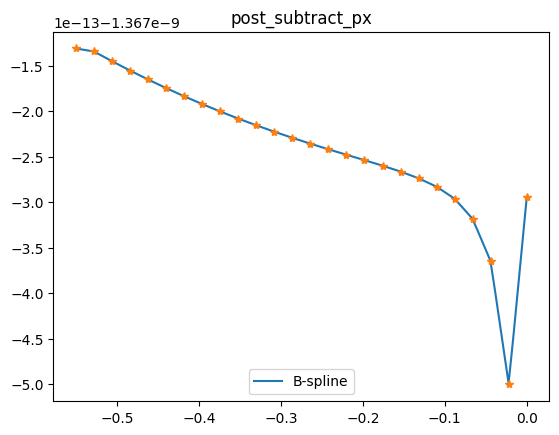

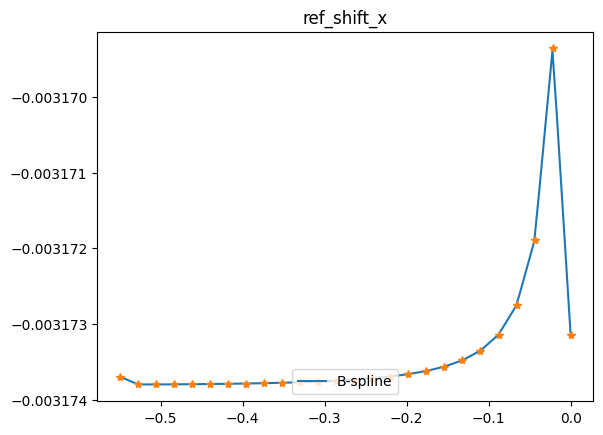

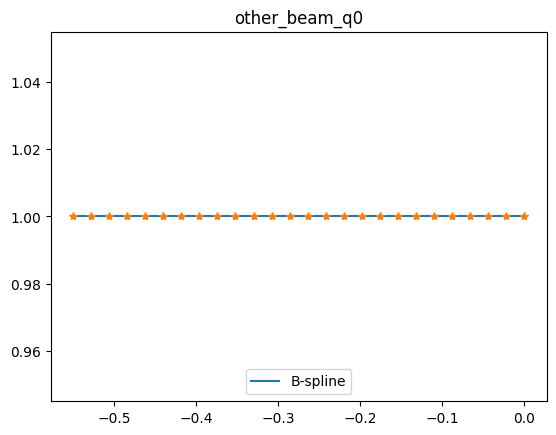

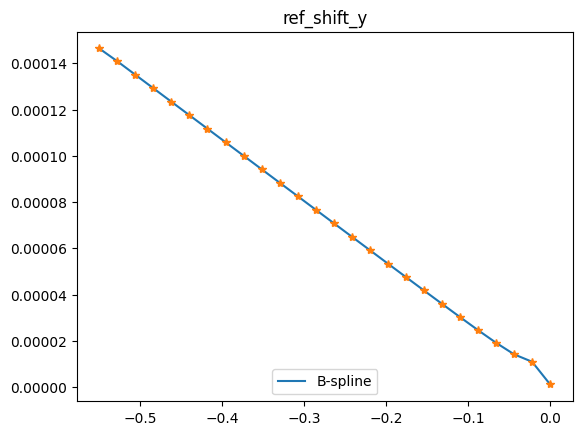

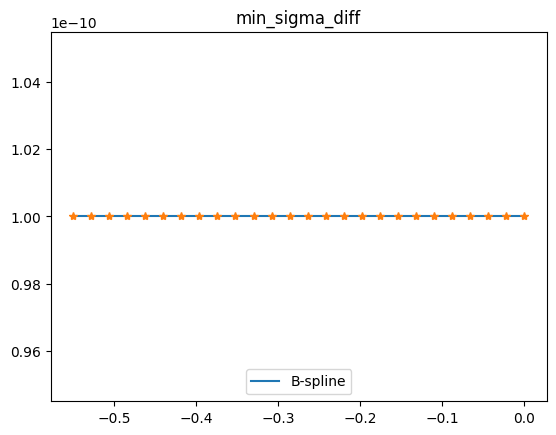

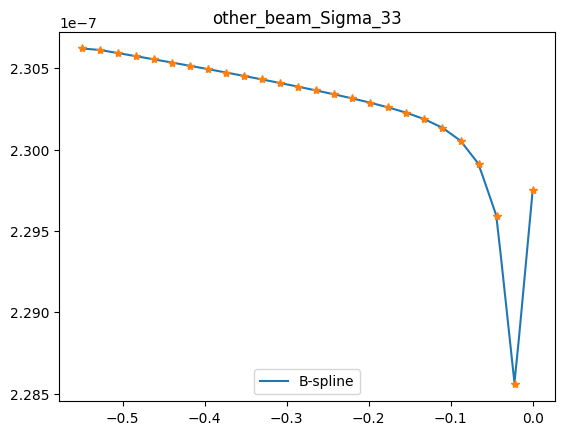

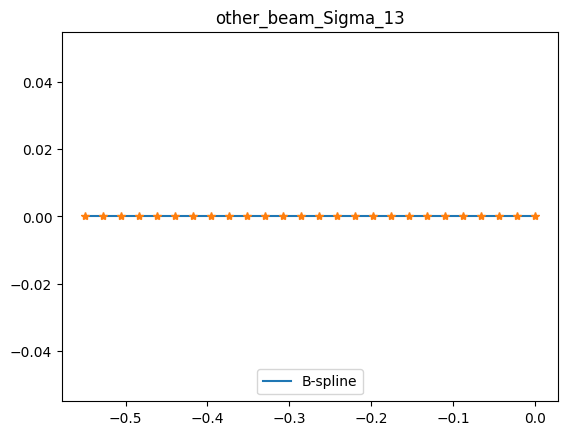

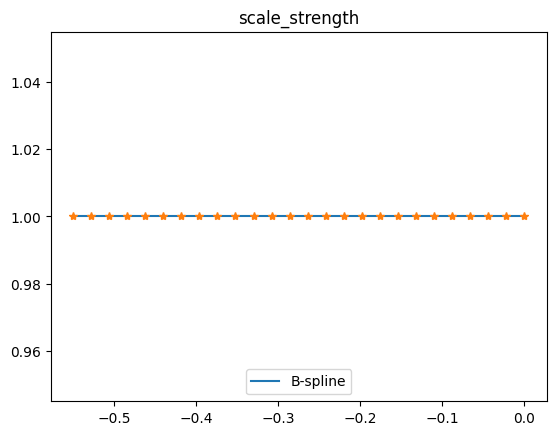

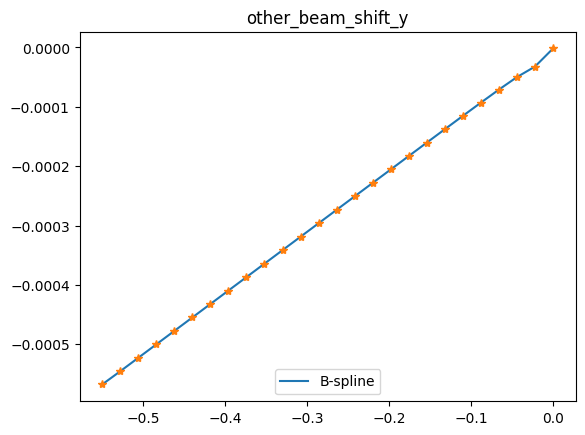

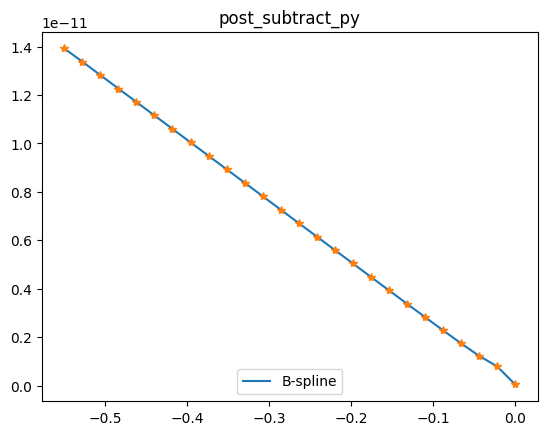

In [6]:
array_xrange = np.linspace(l_xrange[0], l_xrange[-1], 100)
for attr in d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25']:

    fig, ax = plt.subplots()
    y_plot = np.interp(array_xrange, l_xrange, d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25'][attr])
    ax.plot(array_xrange, y_plot, label="B-spline")
    ax.plot(l_xrange, d_element_attr_vals["lhcb1"]['bb_lr.l5b1_25'][attr], '*')
    ax.legend(loc="lower center")
    ax.set_title(attr)
    #ax.set_ylim(-20, 10)
    plt.show()

In [7]:
def interp(x, l_xrange, l_yrange):
    assert isinstance(x, float) or isinstance(x, int)
    for x1, x2, y1, y2 in zip(l_xrange[:-1], l_xrange[1:], l_yrange[:-1], l_yrange[1:]):
        if x1 <= x <= x2:
            return y1 + (y2 - y1) * (x - x1) / (x2 - x1)
            
def make_linear_interp(model):
    return lambda x: interp(x, model['l_xrange'], model['attr'])

d_element_attr_regression = {"lhcb1": {}, "lhcb2": {}}
for beam in d_element_attr_regression:
    d_element_attr_regression[beam] = {}
    for element in d_element_attr_vals[beam]:
        d_element_attr_regression[beam][element] = {}
        for attr in d_element_attr_vals[beam][element]:
            model = {'l_xrange' : l_xrange, 'attr': d_element_attr_vals[beam][element][attr]}
            d_element_attr_regression[beam][element][attr] = make_linear_interp(model)


In [8]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["other_beam_shift_y"](-0.3)

-0.0003106570594072379

In [9]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["min_sigma_diff"](-0.3)

1e-10

In [10]:
# Create knob for beam-beam in collider
for beam in d_element_attr_regression:
    for element in d_element_attr_regression[beam]:
        if 'l1' or 'r1' in element:
            sep = 'on_sep1'
        elif 'l5' or 'r5' in element:
            sep = 'on_sep5'
        else:
            continue
        for attr in d_element_attr_regression[beam][element]:
            collider[beam].vars[f'interp_{attr}'] = d_element_attr_regression[beam][element][attr]
            if (
                isinstance(getattr(collider[beam][element], attr), list)
                or isinstance(getattr(collider[beam][element], attr), np.ndarray)
            ):
                setattr(collider[beam].element_refs[element],attr[0], collider[beam].vars[f'interp_{attr}'](collider.vars[sep]))  
            else:
                setattr(collider[beam].element_refs[element],attr, collider[beam].vars[f'interp_{attr}'](collider.vars[sep]))  

In [11]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["other_beam_shift_y"](-0.3)

-0.0003106570594072379

In [12]:
d_element_attr_regression['lhcb1']["bb_lr.l5b1_25"]["min_sigma_diff"](-0.3)

1e-10

In [13]:
collider.lhcb1["bb_lr.l5b1_25"].min_sigma_diff

1e-10

In [3]:
collider.build_trackers()

Compiling ContextCpu kernels...


3893d6f3640147999d318132a31b59a8.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 3893d6f3640147999d318132a31b59a8.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
3893d6f3640147999d318132a31b59a8.c: In function ‘compt_do’:
3893d6f3640147999d318132a31b59a8.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
3893d6f3640147999d318132a31b59a8.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
3893d6

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


8df907d1ba5042afa8dcf8e801ecfcf3.c:5035: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 8df907d1ba5042afa8dcf8e801ecfcf3.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
8df907d1ba5042afa8dcf8e801ecfcf3.c: In function ‘compt_do’:
8df907d1ba5042afa8dcf8e801ecfcf3.c:18160:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
8df907d1ba5042afa8dcf8e801ecfcf3.c:18157:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
8df907

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [18]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = 0.0010999910758806722

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = vars['interp_other_beam_shift_y'](vars['on_sep1'])

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.55
   vars['interp_other_beam_shift_y'] = <function make_linear_interp.<locals>.<lambda> at 0x7fab0ee7e950>

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



In [19]:
collider.vars['on_sep1']._value

-0.55

In [20]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = 0.0010999910758806722

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = vars['interp_other_beam_shift_y'](vars['on_sep1'])

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.55
   vars['interp_other_beam_shift_y'] = <function make_linear_interp.<locals>.<lambda> at 0x7fab0ee7e950>

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



In [21]:
collider.lhcb1.element_refs["bb_lr.l5b1_25"].other_beam_shift_y._info()

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._get_value()
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = 0.0010999910758806722

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr
   eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y = vars['interp_other_beam_shift_y'](vars['on_sep1'])

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y._expr._get_dependencies()
   vars['on_sep1'] = -0.55
   vars['interp_other_beam_shift_y'] = <function make_linear_interp.<locals>.<lambda> at 0x7fab0ee7e950>

#  eref['lhcb1']['bb_lr.l5b1_25'].other_beam_shift_y does not influence any target



### Ensure that the dynamic kbob delivers the same results at xsuite reconfiguration

In [5]:
def configure_beam_beam(collider, config_bb):
    collider.configure_beambeam_interactions(
        num_particles=config_bb["num_particles_per_bunch"],
        nemitt_x=config_bb["nemitt_x"],
        nemitt_y=config_bb["nemitt_y"],
    )

    # Configure filling scheme mask and bunch numbers
    if "mask_with_filling_pattern" in config_bb:
        # Initialize filling pattern with empty values
        filling_pattern_cw = None
        filling_pattern_acw = None

        # Initialize bunch numbers with empty values
        i_bunch_cw = None
        i_bunch_acw = None

        if "pattern_fname" in config_bb["mask_with_filling_pattern"]:
            # Fill values if possible
            if config_bb["mask_with_filling_pattern"]["pattern_fname"] is not None:
                fname = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/master_jobs/filling_scheme/25ns_2464b_2452_1842_1821_236bpi_12inj_hybrid_converted.json"  # config_bb["mask_with_filling_pattern"]["pattern_fname"]
                with open(fname, "r") as fid:
                    filling = json.load(fid)
                filling_pattern_cw = filling["beam1"]
                filling_pattern_acw = filling["beam2"]

                # Only track bunch number if a filling pattern has been provided
                if "i_bunch_b1" in config_bb["mask_with_filling_pattern"]:
                    i_bunch_cw = 411
                if "i_bunch_b2" in config_bb["mask_with_filling_pattern"]:
                    i_bunch_acw = 410

                # Note that a bunch number must be provided if a filling pattern is provided
                # Apply filling pattern
                collider.apply_filling_pattern(
                    filling_pattern_cw=filling_pattern_cw,
                    filling_pattern_acw=filling_pattern_acw,
                    i_bunch_cw=i_bunch_cw,
                    i_bunch_acw=i_bunch_acw,
                )

    return collider


# Read configuration for simulations
with open(
    "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/dynamic_collapse_new/base_collider/xtrack_0000/gen_3/gen_4/gen_5_debug/config.yaml",
    "r",
) as fid:
    config = ryaml.load(fid)

config_bb = config["config_collider"]["config_beambeam"]
#collider = configure_beam_beam(collider, config_bb)

Compiling ContextCpu kernels...


be9b11ab5ff3454490ef71d6e1572f47.c:5040: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from be9b11ab5ff3454490ef71d6e1572f47.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
be9b11ab5ff3454490ef71d6e1572f47.c: In function ‘compt_do’:
be9b11ab5ff3454490ef71d6e1572f47.c:18165:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
be9b11ab5ff3454490ef71d6e1572f47.c:18162:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
be9b11

Done compiling ContextCpu kernels.
bb_lr.l1b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_20 Ref

868d8519fd724ddea83c981a8cc360ce.c:3702: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from 868d8519fd724ddea83c981a8cc360ce.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


bbf1ee29eb61407fab1323d93ea302c9.c:7252: warning: "_GNU_SOURCE" redefined
 #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
 
In file included from bbf1ee29eb61407fab1323d93ea302c9.c:50:
/afs/cern.ch/work/c/cdroin/private/example_DA_study/miniforge/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 #define _GNU_SOURCE 1
 
bbf1ee29eb61407fab1323d93ea302c9.c: In function ‘compt_do’:
bbf1ee29eb61407fab1323d93ea302c9.c:10637:12: warning: unused variable ‘e_loss_primary_tot’ [-Wunused-variable]
     double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
            ^~~~~~~~~~~~~~~~~~
bbf1ee29eb61407fab1323d93ea302c9.c:10634:62: warning: variable ‘ps_e_prime’ set but not used [-Wunused-but-set-variable]
     double e_e_prime, px_e_prime, py_e_prime, pzeta_e_prime, ps_e_prime, pt_e_prime;  // [GeV, 1, 1, 1, 1, 1] scattered primary
                                                              ^~~~~~~~~~
bbf1ee

Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


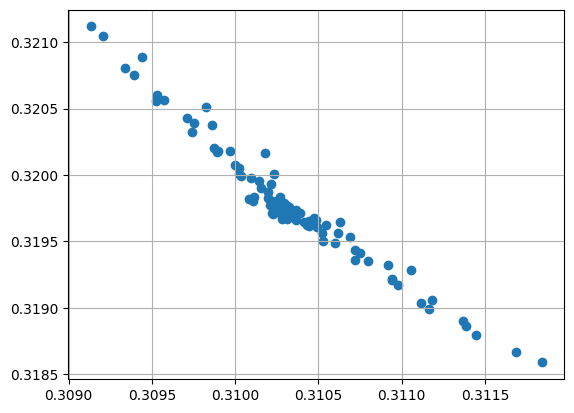

bb_lr.l1b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_20 Reference systems are not parallel
Sma

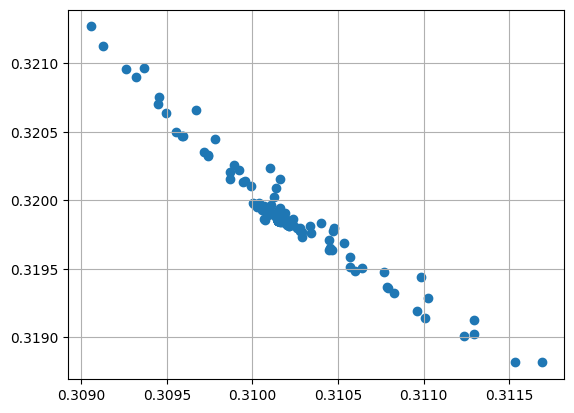

Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


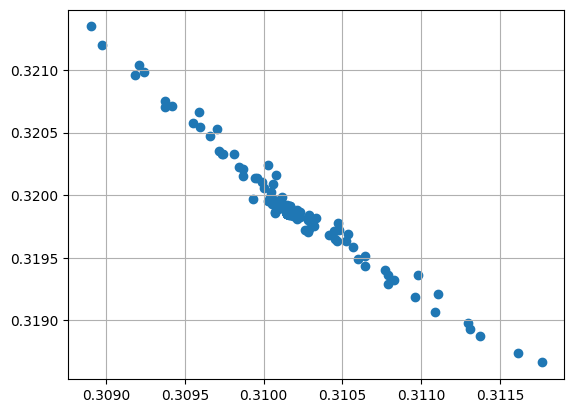

bb_lr.l1b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_20 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_21 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_22 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_23 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_24 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l1b1_25 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_17 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_18 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_19 Reference systems are not parallel
Smaller that 5e-3, tolerated.
bb_lr.l5b1_20 Reference systems are not parallel
Sma

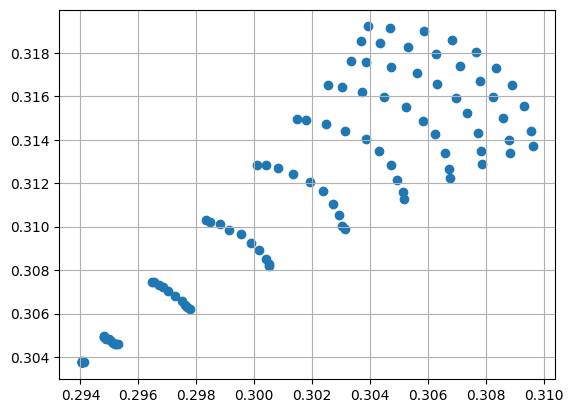

In [9]:
# Function to compute footprint
def return_footprint(collider, emittance, beam="lhcb1", n_turns=2000):
    fp_polar_xm = collider[beam].get_footprint(
        nemitt_x=emittance,
        nemitt_y=emittance,
        n_turns=n_turns,
        linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.05)],
        freeze_longitudinal=True,
    )

    qx = fp_polar_xm.qx
    qy = fp_polar_xm.qy

    return qx, qy



collider.vars['on_sep1'] = -0.3
collider.vars['on_sep5'] = -0.3
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()
plt.close()

# Reconfigure beam-beam
collider = configure_beam_beam(collider, config_bb)
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()
plt.close()

# Change knob
collider.vars['on_sep1'] = -0.00
collider.vars['on_sep5'] = -0.00
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()
plt.close()

# Reconfigure beam-beam
collider = configure_beam_beam(collider, config_bb)
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()
plt.close()


Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


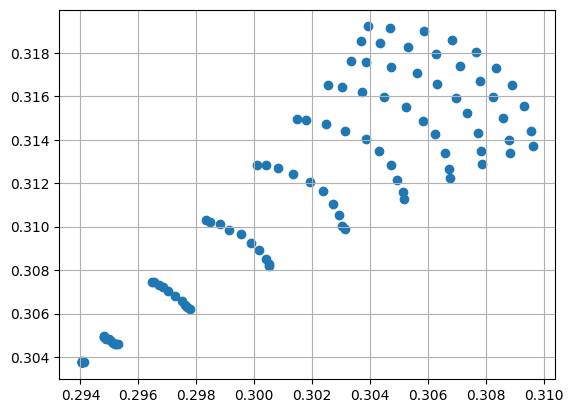

In [13]:
# Change knob
collider.vars['on_sep1'] = -0.003
collider.vars['on_sep5'] = -0.003
qx, qy = return_footprint(collider, 2e-6, beam="lhcb1", n_turns=500)
plt.scatter(qx, qy)
plt.grid()
plt.show()
plt.close()